<a href="https://colab.research.google.com/github/CaptenSepp/DoReMi/blob/annika/CNN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# imports
import torch
from torch import tensor
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms # for datset transformation
from torchvision.datasets import MNIST  # predefined MNSIT dataset
from torch.utils.data import DataLoader # DataLoader Class
import numpy as np # used to handle data set
import matplotlib.pyplot as plt # to visualize data set
%matplotlib inline
import os #  to load data
import random # for seeding
from prettytable import PrettyTable
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

Exception reporting mode: Verbose
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 4 4
64 16 

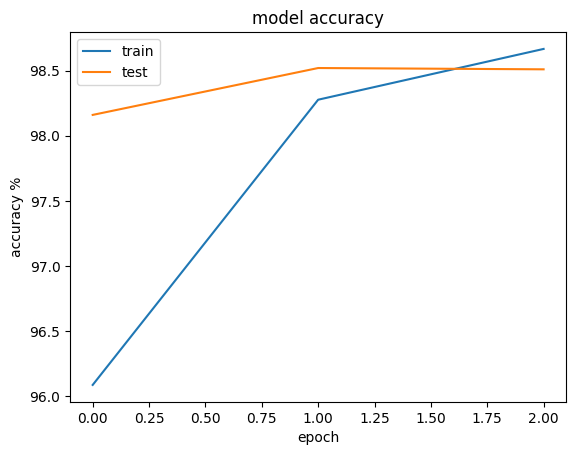

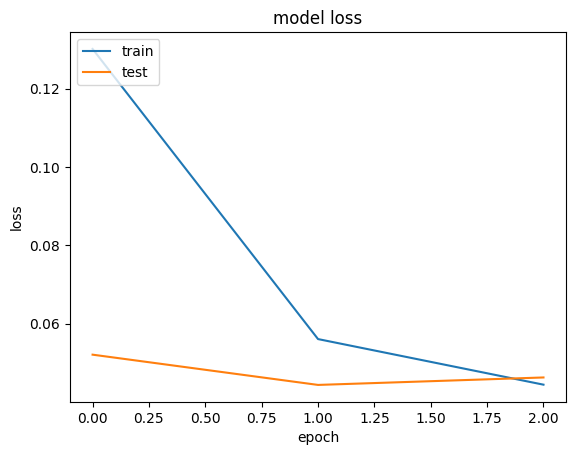

In [ ]:
#------------------------------------------------------------------------------#
# debug modus
%xmode Verbose
#Use GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device
#------------------------------------------------------------------------------#
# defining methods
def plot_hist(history):
  """Plots the training and testing accuracy and loss
  Argument:
    history: a dictionairy

    Dictionairy keys:
      <train_acc>   : list, stores the training accuracy for each epoch
      <test_acc>    : list, stores the testing accuracy for each epoch
      <train_loss>  :list, stores the average training loss for each epoch
      <test_loss>   : list, stores the average training loss for each epoch
  """
  # plot accuracy history
  plt.plot(history['train_acc'])
  plt.plot(history['test_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy %')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # plot loss history
  plt.plot(history['train_loss'])
  plt.plot(history['test_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  # show plot
  plt.show()
#---------------------
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
#---------------------------------
def train(model, train_loader, optimizer, criterion):
    model.train()
    epoch_loss  = []
    correct     = 0

    for imgs, labels in train_loader:
        optimizer.zero_grad()
      # forward propagation
        out = model(imgs)
        loss = criterion(out, labels)
        #backpropagation
        loss.backward()
        optimizer.step()
        # logging
        epoch_loss.append(loss.item())

        prediction = torch.argmax(out, dim=1)
        correct += torch.sum(labels == prediction).item()

    return np.mean(epoch_loss), correct
#----------------------------
def evaluate(model, data_loader, criterion):
    model.eval()
    epoch_loss = []
    correct    = 0

    with torch.no_grad():
        for imgs, labels in data_loader:
            out = model(imgs)
            loss = criterion(out, labels)
            # logging
            epoch_loss.append(loss.item())
            # accuracy
            prediction = torch.argmax(out, dim=1)
            correct += torch.sum(labels == prediction).item()

    return np.mean(epoch_loss), correct
#------------------------- Definition Model -----------------------------------#
# defining the model
class Classifier(nn.Module):
  # Konstruktor
  def __init__(self, in_feat):
    super().__init__()
    # Anzahl der Layer und Eingangs-und Ausgangsneuronen festlegen
    self.inLayer=nn.Linear(in_feat, 128)
    self.hidLayer=nn.ReLU()
    self.outLayer=nn.Linear(128, num_classes)# ohne Aktivierungsfunktion, weil das von CrossEntropyLoss übernommen wird

  #  4.3 Forward-Funktion definieren
  def forward(self, x): # zwingend Bestandteil eines NN
    data, target = x
    x=x.view(-1,1*28*28)  # macht aus einem 2D-Schwarz/weiß-Bild ein 1D-Array
    y= self.inLayer(x)
    z= self.hidLayer(y)
    prediction =self.outLayer(z)

    return prediction
class cnn(nn.Module):
  # Konstruktor
  def __init__(self, in_feat, num_label):
    super().__init__()

    # layer
    self.inLayer= nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding='valid') # feaure_map=28-5+1=24
    self.actv=nn.ReLU()   # muss nur einmalig definiert werden, in forward() aber nach jeder conv2d angewendet werden
    self.maxpool_1= nn.MaxPool2d(kernel_size= 2, stride=2)  # feature_map= 24*(1/2)=12
    self.bn_1=nn.BatchNorm2d(num_features=6)  # num_features ==out_channels of Conv2d

    self.conv_2=nn.Conv2d(in_channels=6 , out_channels =16 , kernel_size=5)  #feature_map= 12-5+1=8
    self.maxpool_2= nn.MaxPool2d(kernel_size= 2, stride=2)  # feature_map = 8 * (1/2)=4
    self.bn_2=nn.BatchNorm2d(num_features=16)

    self.linLayer_2= nn.Linear(in_features=256, out_features=120) # 256= 4*4*16 (Layer-größe mal Layer-Anzahl)
    self.linLayer_3= nn.Linear(in_features=120, out_features=84)
    self.outLayer=nn.Linear(in_features= 84, out_features=num_label)
  # forward
  def forward(self, x):
    # reshaping
    x = x.view(-1, 1, 28, 28)

    x=self.inLayer(x)
    x=self.actv(x)
    x=self.maxpool_1(x)
    x=self.bn_1(x)

    x=self.conv_2(x)
    x=self.actv(x)
    x=self.maxpool_2(x)
    x=self.bn_2(x)

    # flatten data
    bs,c,h,w =x.shape     # batchSize, num_of_channels, height, width
   # print(bs,c,h,w)
    x= x.view(bs,c*h*w)
   # x= x.view(x.size(0),-1)

    x=self.linLayer_2(x)
    x=self.linLayer_3(x)
    prediction=self.outLayer(x)

    return prediction




#------------------------- Eingabe -----------------------------------------#
# Create folders
!mkdir -p MNIST_data/train # -p creates the missing parten directory, if it does not exist
!mkdir -p MNIST_data/test # -p creates the missing parten directory, if it does not

# parameters needed for model and data
mean = 0.1307
std = 0.3081
lr = 0.001
momentum = 0.9
epochs = 3
in_feat= 28*28
num_classes= 10
# Load MNIST dataset into new folders
dataset_train = MNIST(
    root = "MNIST_data/train"
    ,train = True # load train split
    ,download = True  # download if not existing
    ,transform = transforms.Compose([
      transforms.ToTensor() # create a tensor from the underlying PIL image
      ,transforms.Normalize(mean, std)   # separate standardization per feature
    ])
)

dataset_test = MNIST(
    root = "MNIST_data/test"
    ,train = False # load test split
    ,download = True  # download if not existing
    ,transform = transforms.Compose([
      transforms.ToTensor() # create a tensor from the underlying PIL image
      ,transforms.Normalize(mean, std)   # separate standardization per feature
    ])
)
# create trainloader-instanzes
train_loader = DataLoader(dataset = dataset_train, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset = dataset_test, batch_size=64, shuffle=False )
################################################################################
################################################################################
#---------------------- Model instanzieren ---------------------#
model = cnn(in_feat, num_classes)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
# lists for logging
  #accuracy cmoputated in two different ways
#acc_met_train = torchmetrics.classification.Accuracy(task="multiclass", num_classes=10)
#acc_met_test = torchmetrics.classification.Accuracy(task="multiclass", num_classes=10)
accuracy_hist_train = []  # List to store manually computated training accuracy for each epoch
accuracy_hist_test = []   # List to store manually computated testing accuracy for each epoch
  # F1-Score
#f1_metric_train = BinaryF1Score(multidim_average='samplewise')
#f1_metric_test = BinaryF1Score(multidim_average='samplewise')
  # combined metric

  # loss
loss_hist_train =[]
loss_hist_test =[]
################################################################################
#--------------------- Model trainieren Epochenstart --------------------------#
for epoch in range(epochs):
  # training
  train_loss, train_correct = train(model, train_loader, optimizer, criterion)
  # testing
  test_loss, test_correct = evaluate(model, test_loader, criterion)
  # metrics
    # accuracy computation manually
  train_acc = 100 * train_correct / len(dataset_train)
  test_acc = 100 * test_correct / len(dataset_test)
  accuracy_hist_train.append(train_acc)
  accuracy_hist_test.append(test_acc)
    # loss
  epoch_loss_train = np.mean(train_loss)
  epoch_loss_test = np.mean(test_loss)
  loss_hist_train.append(epoch_loss_train)
  loss_hist_test.append(epoch_loss_test)
    # F1-Score
#  train_f1 = f1_metric_train.compute()
#  test_f1 = f1_metric_test.compute()
#  f1_metric_hist_train.append(train_f1) # aktuell nicht genutzt
#  f1_metric_hist_test.append(test_f1)   # aktuell nicht genutzt'
  # display results
  print(f"Epoch {str(epoch).zfill(3)}")
  print(f"TRAIN\t loss: {round(train_loss, 4)}\t accuracy-manual: {round(train_acc, 4)}")#, "\t Accuracy-Metric", acc_train, "\t F1-Score ", train_f1)
  print(f"TEST\t loss: {round(test_loss, 4)}\t manual accuracy: {round(test_acc, 4)}")#,"\t Accuracy-Metric Testing: ", acc_test, "\t F1-Score: ", test_f1)
  print( )

# Pack history
history = {
    "train_acc"   : accuracy_hist_train,
    "test_acc"    : accuracy_hist_test,
    "train_loss"  : loss_hist_train,
    "test_loss"   : loss_hist_test
}
# show visualization
plot_hist(history)

### TODO ###
# Daten flatten vor LinearLayer_2

In [ ]:
!pip show torchmetrics